# PA004: Health Insurance cross sell

##  Planejamento da solução (IOT)

### Database

Information about customers who participate in a survey by answering whether they would be interested in car insurance.

### Input

1. Build a model to order customers most likely to buy vehicle insurance.

### Business Questions

1. Main Insights on the most relevant attributes of customers interested in purchasing auto insurance.




2. What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?





3. If the sales team capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?






4. How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

### Output

1. Customers interested in car insurance for the sales team to call.

       Customer Id |   interest % 
           01      |     0.99
           02      |     0.97
           03      |     0.90
    
2. Report with business Questions

### Tasks

  1. Model to rank customers by higher interest in car insurance
  
  
  
  

  2. Exploratory Data Analysis Report about the top feature importance





  3. The number of customers interested in car insurance

# 0.0. IMPORTS

In [4]:

import pickle 
import requests

import seaborn                                                     as sns
import pandas                                                      as pd
import psycopg2                                                    as pg
import numpy                                                       as np
import scikitplot                                                  as skplt

from matplotlib                    import pyplot                   as plt


from IPython.core.display          import HTML

# machine learning

from sklearn                       import preprocessing            as pp
from sklearn                       import model_selection          as ms
from sklearn                       import ensemble                 as en
from sklearn                       import neighbors                as nk   
from sklearn                       import linear_model             as lm
from catboost                      import CatBoostClassifier       as cb

# metrics
from scikitplot.metrics            import plot_lift_curve, plot_cumulative_gain
from sklearn.metrics               import roc_auc_score


from flask import Flask, request, Response

import warnings

warnings.filterwarnings("ignore")

## 0.1 Loading Data - Postgres

In [5]:
path = '/home/felipepedrosa/projetos/health_insurance'

In [6]:
#  # Credentials
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = 5432
# database = 'comunidadedsdb'
# username = 'member'
# pwd = 'cdspa'

In [7]:
 # credentials
# hodt = os.environ.get( 'DB_HOST' )
# port = os.environ.get( 'DB_PORT' ) 
# database = os.environ.get( 'DB_DATABASE' )
# username = os.environ.get( 'DB_USERNAME' ) 
# pwd = os.environ.get( 'DB_PASSWORD' )

In [8]:
# conn = pg.connect(user = username, password = pwd, host = host, port = port, database = database)

# query_schema = '''
#     SELECT *
#     FROM pa004.users u  INNER JOIN pa004.vehicle v on (u.id = v.id)
#                         INNER JOIN pa004.insurance i on (u.id = i.id)
# '''

# df_raw = pd.read_sql(query_schema, conn)

# conn.close()

# df_raw.to_pickle(path + '/data/raw/df_raw.pkl')

In [9]:
df1 = pd.read_pickle(path + '/data/raw/df_raw.pkl') 

## 0.2 Helper Functions

In [10]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.8f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [11]:
def descriptive_stats(df): 
    # Central Tendency - Mean, Median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [12]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [13]:
# Metrics @ k

def metrics_at_k(data, model, x_train, y_train, x_val, y_val, sort=True, verbose=False):
    
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)

    model_df = []
    trained_models = []
    i = 1
    j = len(model)
    for m in model:
        m_name = type(m).__name__
        if verbose:
            print(f"ML - Training model {i}/{j} -> " + m_name + "..." )
        m.fit(x_train, y_train)

        trained_models.append(m)

        # probabilities prediction
        yhat = m.predict_proba(x_val)

        # copy data
        data = x_val.copy()
        data['response'] = y_val.copy()

        # propensity score
        data['score'] = yhat[:, 1].tolist()

        # sort clients by propensity score
        data = data.sort_values('score', ascending=False)

        precision = precision_at_k(data)
        recall = recall_at_k(data)

        i += 1

        df = pd.DataFrame({'Model_Name': m_name, 'Precision@K': precision,
                           'Recall@K': recall}, index=[0]).sort_values('Precision@K', ascending=False)

        model_df.append(df)
        final_model = pd.concat(model_df)
    return final_model.sort_values(by='Precision@K', ascending=False).round(4), trained_models

In [14]:
# cross validation
def cross_validation( data, model, x_train, y_train, k, sort=True, verbose=False ):
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)

    kfold = ms.StratifiedKFold(n_splits=k, shuffle=True, random_state=17)
    precision_list = []
    recall_list = []
    model_df = []
    j = 1
    l = len(model)

    for m in model:
        i = 1
        m_name = type(m).__name__
        if verbose:
            print(f"CV - Folding model {j}/{l} -> " + m_name + "..." )
        for train_cv, val_cv in kfold.split(x_train, y_train):
            if verbose:
                print(f'Fold Number {i}/{k}')
            x_train_fold = x_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]
            x_val_fold = x_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]

            model_fit = m.fit(x_train_fold, y_train_fold)
            yhat = m.predict_proba(x_val_fold)

            data = x_val_fold.copy()
            data['response'] = y_val_fold.copy()
            data['score'] = yhat[:, 1].tolist()
            data = data.sort_values('score', ascending=False)

            precision = precision_at_k(data)
            precision_list.append(precision)

            recall = recall_at_k(data)
            recall_list.append(recall)

            i += 1

        df = pd.DataFrame({'Model_Name': m_name,
                           'Precision@K Mean': np.mean(precision_list).round(4),
                           'Precision@K STD': np.std(precision_list).round(4),
                           'Recall@K Mean': np.mean(recall_list).round(4),
                           'Recall@K STD': np.std(recall_list).round(4)}, index=[0])
        j += 1
        model_df.append(df)
        final_model = pd.concat(model_df)

    return final_model

In [15]:
 # Plot cumulative Gain Curve & Lift Curve
def plot_cgc_lc(model, x_train, y_train, x_val, sort=True, fit=True, verbose=False ):
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)
    i = 1
    j = len(model)
    for m in model:
        m_name = type(m).__name__
        if verbose: 
            print(f"Calulating curve for model {i}/{j} -> " + m_name + "..." )
        if fit:
            if verbose:
                print(f"Training model ... ")
            m.fit(x_train, y_train)
                
        # probabilities prediction
        yhat_model = m.predict_proba(x_val)
        fig, axs = plt.subplots(ncols=2, figsize=(20,6))
        plot_cumulative_gain(y_val, yhat_model, ax=axs[0], text_fontsize='small', title='Cumulative Gain Curve - ' + m_name) # Cumulative Gain Curve
        plot_lift_curve(y_val, yhat_model, ax=axs[1], text_fontsize='small', title='Lift Curve - ' + m_name); # Lift curve
        i += 1

# 1.0. Data Description


    id:                  Unique ID for the customer
    gender:              Gender of the customer
    age:                 Age of the customer
    driving_license:     0 - Customer does not have DL / 1 - Customer already has DL
    region_code:         Unique code for the region of the customer
    previously_insured:  1 - Customer already has Vehicle Insurance / 0 - Customer doesn't have Vehicle Insurance
    vehicle_age:         age of the Vehicle
    vehicle_damage:      1 - Customer got his/her vehicle damaged in the past / 0 - Customer didn't get his/her vehicle damaged in the past.
    annual_premium:      The amount customer needs to pay as premium in the year
    policy_sales_hannel: Anonymized Code for the channel of outreaching to the customer id. Different Agents, Over Mail, Over Phone, In Person, etc.
    vintage:             Number of Days, Customer has been associated with the company
    response:            1 - Customer is interested / 0 - Customer is not interested}

## 1.1. Organize columns

In [16]:
 # removing duplicated columns
df1 = df1.loc[:, ~ df1.columns.duplicated()]

## 1.2. Data Dimensions

In [17]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [18]:
df1.dtypes 

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [19]:
df1.isna().sum() 

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [20]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.5.1 Numerical Attributes


In [21]:
descriptive_stats(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00000000,381109.00000000,381108.00000000,190555.00000000,190555.00000000,110016.69186992,-0.00000000,-1.20000000
1,age,20.00000000,85.00000000,65.00000000,38.82258357,36.00000000,15.51159067,0.67253900,-0.56565507
2,region_code,0.00000000,52.00000000,52.00000000,26.38880740,28.00000000,13.22987067,-0.11526641,-0.86785712
3,policy_sales_channel,1.00000000,163.00000000,162.00000000,112.03429465,133.00000000,54.20392366,-0.90000812,-0.97081018
4,driving_license,0.00000000,1.00000000,1.00000000,0.99786938,1.00000000,0.04610948,-21.59518153,464.35430215
5,previously_insured,0.00000000,1.00000000,1.00000000,0.45821012,0.00000000,0.49825055,0.16774712,-1.97187125
6,annual_premium,2630.00000000,540165.00000000,537535.00000000,30564.38958146,31669.00000000,17213.13247397,1.76608721,34.00456870
7,vintage,10.00000000,299.00000000,289.00000000,154.34739668,154.00000000,83.67119385,0.00302952,-1.20068804
8,response,0.00000000,1.00000000,1.00000000,0.12256336,0.00000000,0.32793533,2.30190580,3.29878763


# 2.0. Feature Engineering


In [22]:
df2 = df1.copy()

In [23]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.00000000,152.00000000,1,< 1 Year,Yes,0,23367.00000000,249,0
1,13,Female,41,15.00000000,14.00000000,1,1-2 Year,No,1,31409.00000000,221,0
2,18,Female,25,35.00000000,152.00000000,1,< 1 Year,No,1,46622.00000000,299,0
3,31,Female,26,8.00000000,160.00000000,1,< 1 Year,No,0,2630.00000000,136,0
4,39,Male,45,8.00000000,124.00000000,1,1-2 Year,Yes,0,42297.00000000,264,0


In [24]:
# vehicule age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 2 if x == '> 2 Years' else 1 if x == '1-2 Year' else 0 )

# vehiculde damage
df2['vehicle_damage'] = df2['vehicle_damage'].map({'Yes' : 1 , 'No' : 0})


# 3.0. Data Filtering


In [25]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis (EDA)


In [26]:
df4 = df3.copy()

## 4.1. Univariate Analysis


In [27]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

<AxesSubplot:xlabel='response', ylabel='age'>

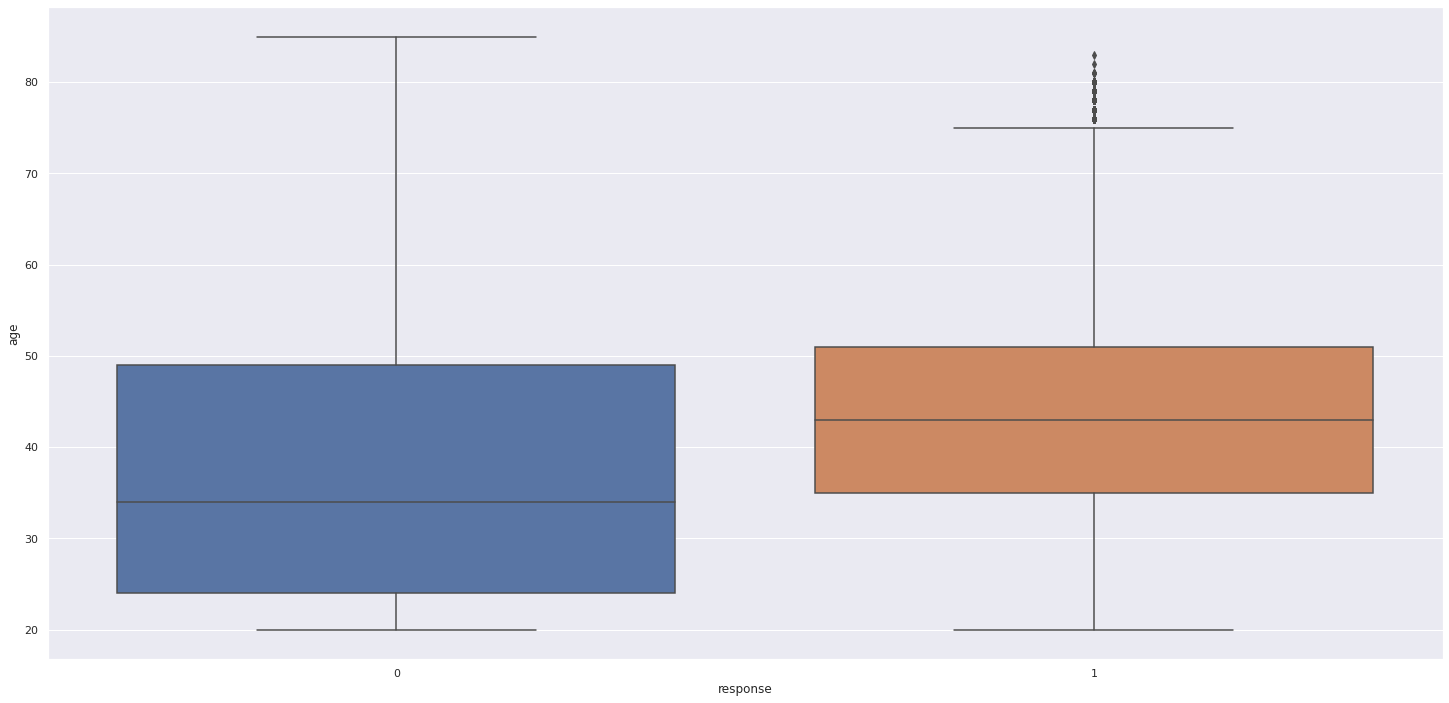

In [28]:
# age
sns.boxplot(x ='response' , y = 'age' , data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

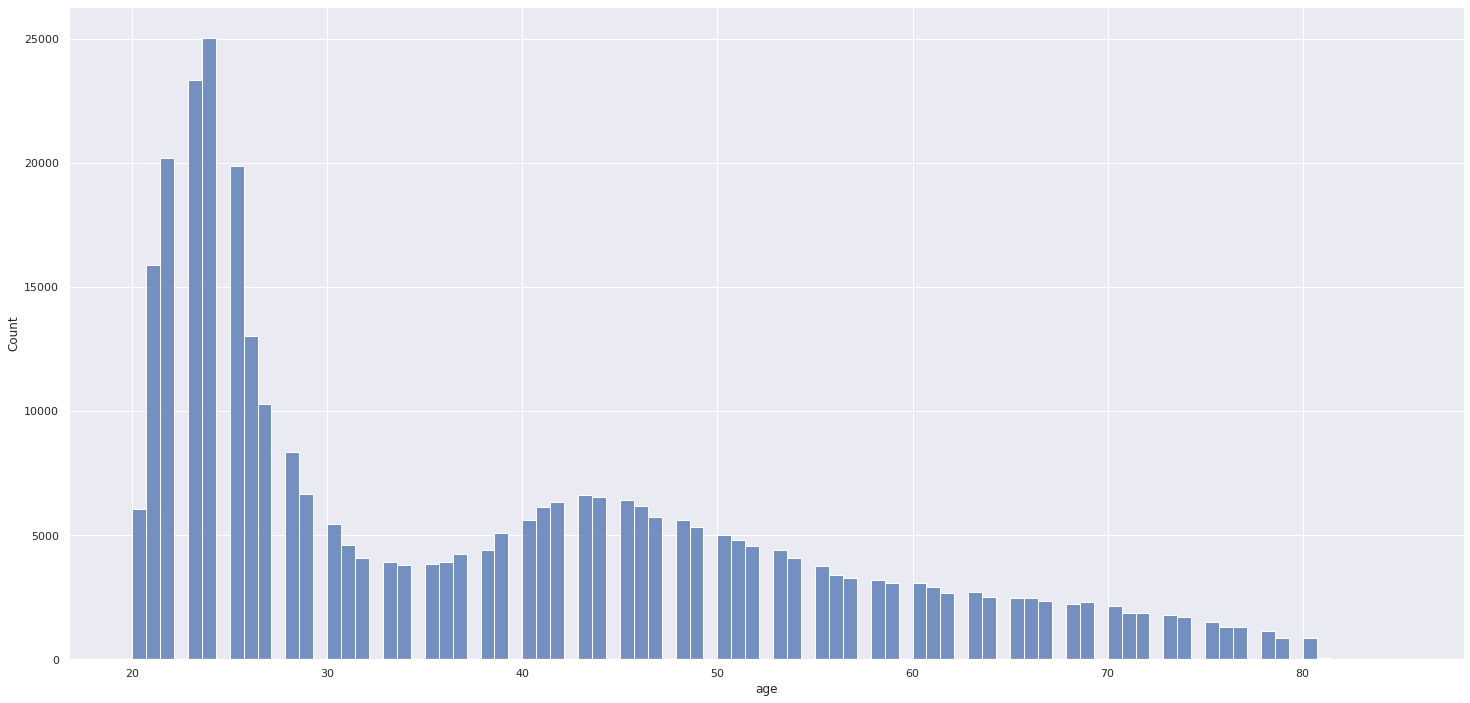

In [29]:
aux00 = df4.loc[df4['response'] == 0,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

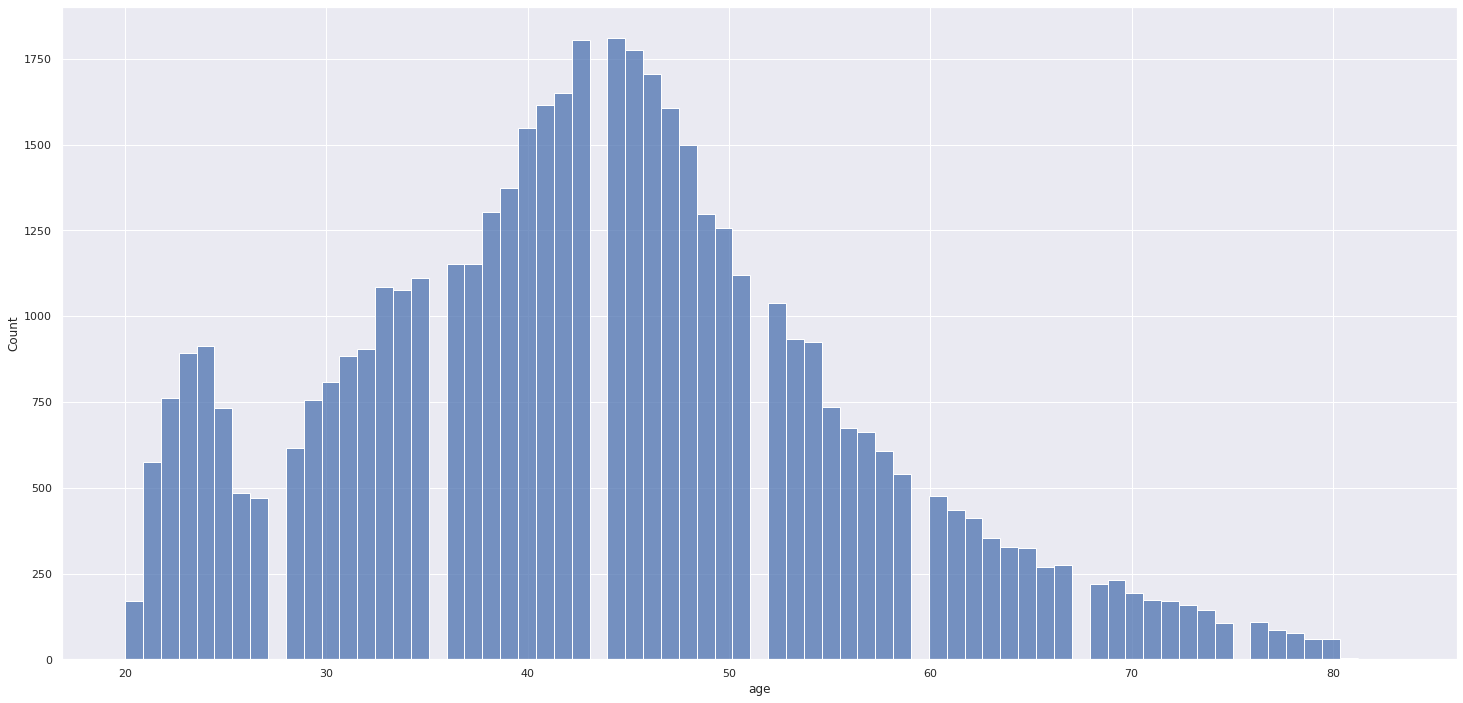

In [30]:
aux00 = df4.loc[df4['response'] == 1,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

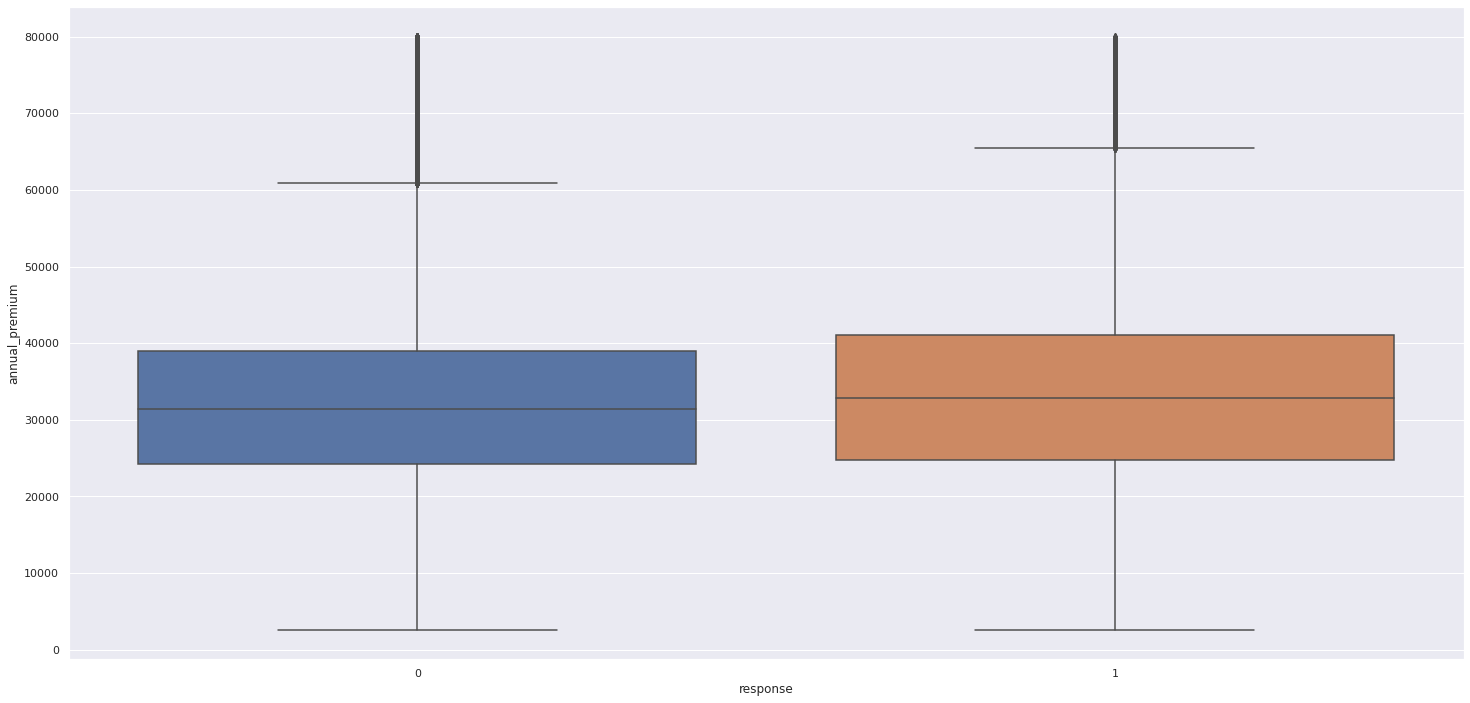

In [31]:
# annual_premium

aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x ='response' , y = 'annual_premium' , data=aux)


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

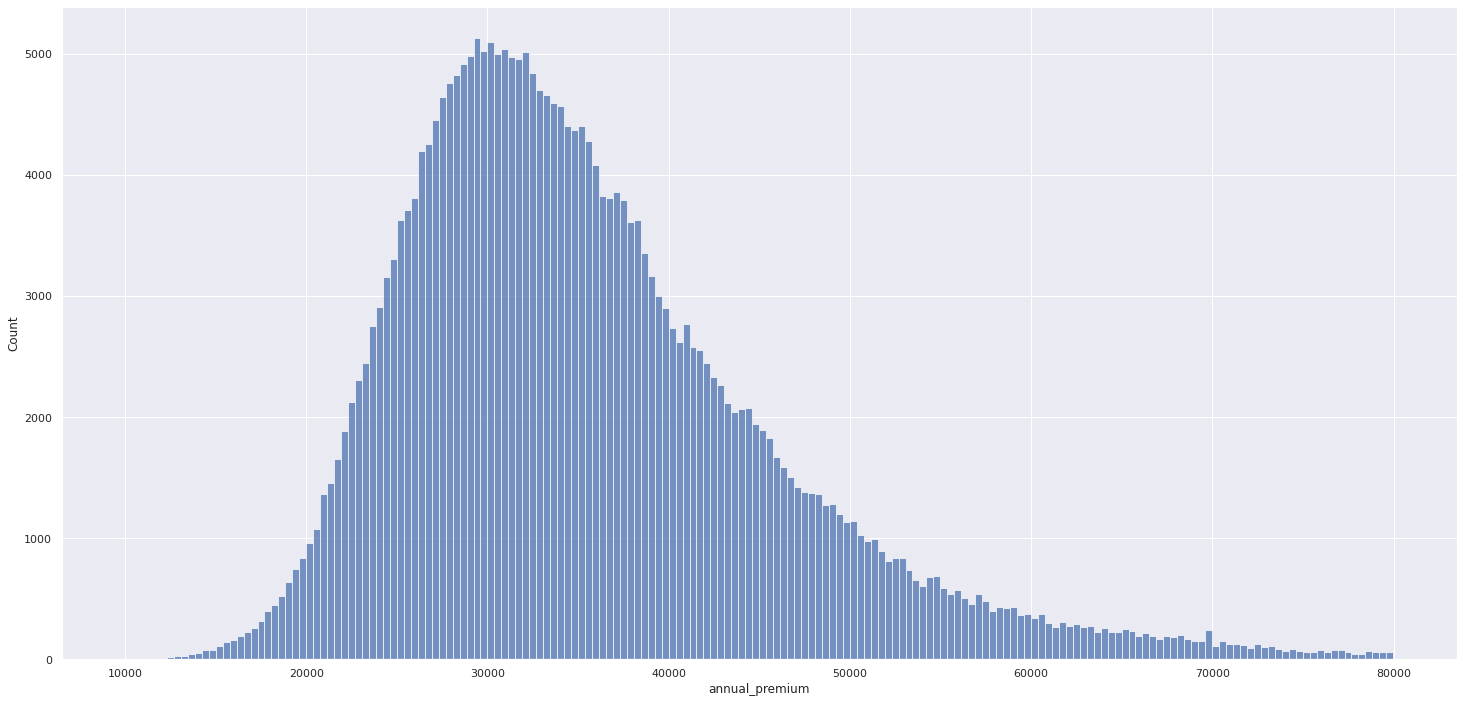

In [32]:
aux = df4[(df4['annual_premium']  > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0,'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

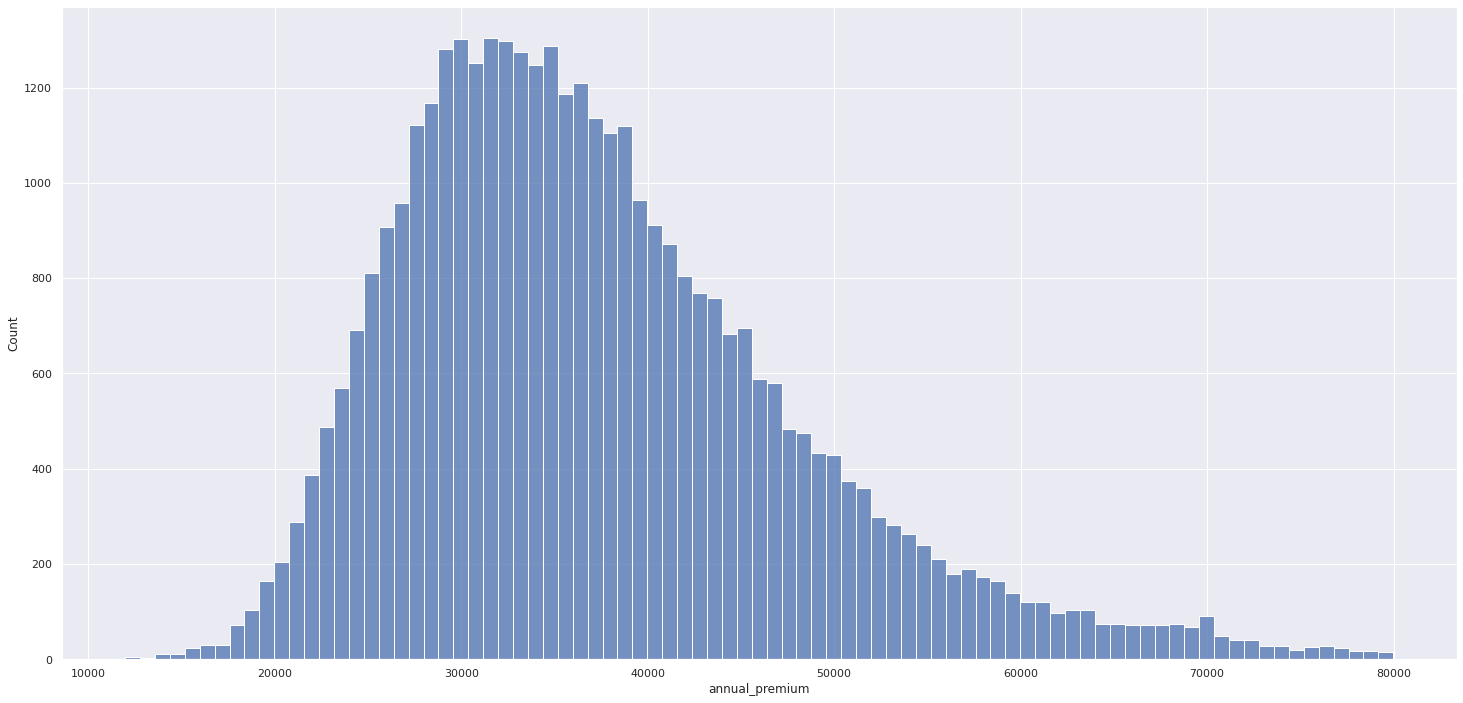

In [33]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 1,'annual_premium']
sns.histplot(aux00)

In [34]:
# driving_license

aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux.head()   
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
# sns.barplot(x ='response' , y = 'driving_license' , data=aux)


In [35]:
aux

,response,driving_license,driving_license_perc
0,0,333628,0.87728276
1,1,46669,0.12271724


<AxesSubplot:xlabel='region_code', ylabel='id'>

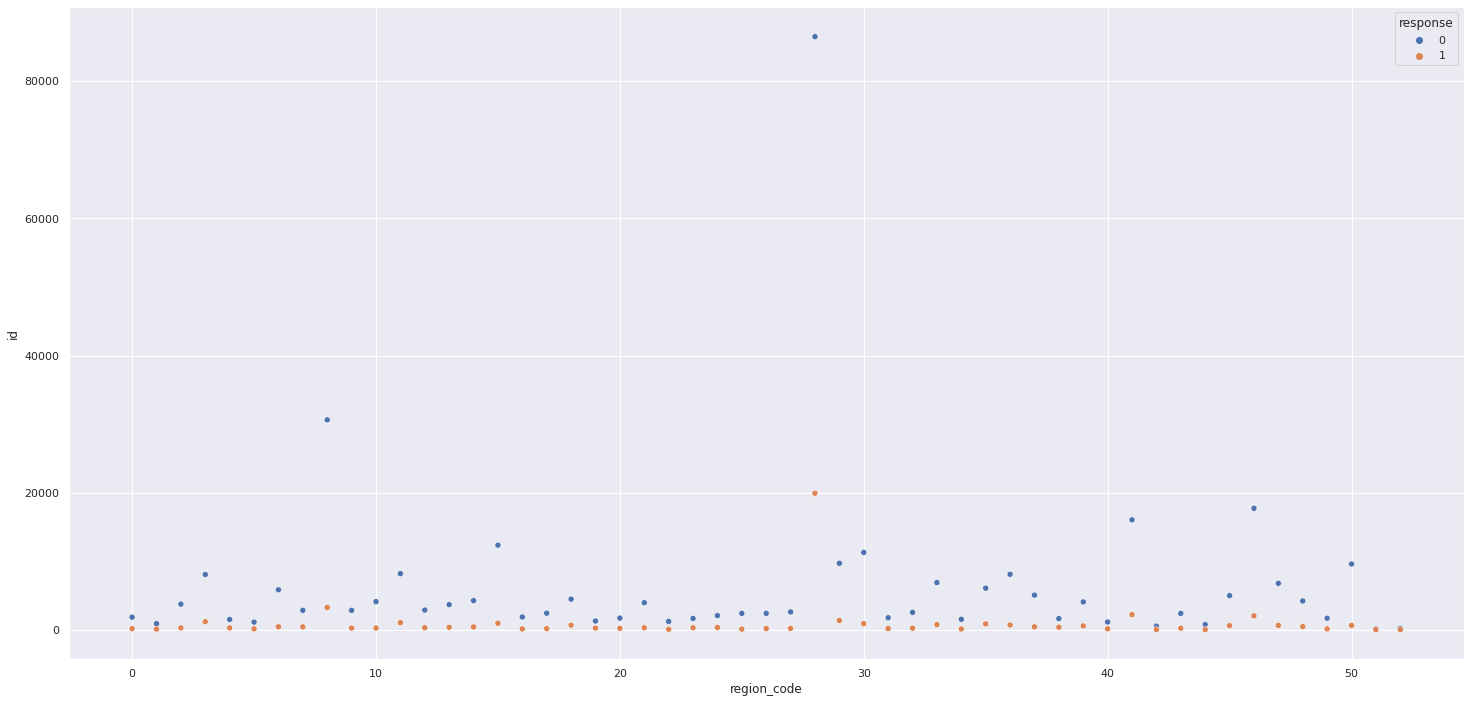

In [36]:
# region_code

aux0 = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()


sns.scatterplot(x= 'region_code' , y='id' , hue='response' , data=aux0)

In [37]:
# previously_insured

pd.crosstab(df4['previously_insured'],df4['response'] ).apply(lambda x: x / x.sum() , axis =1)

response,0,1
previously_insured,,
0,0.77454584,0.22545416
1,0.99909522,0.00090478


In [38]:
# vehicle_age

df4[['vehicle_age' , 'response']].value_counts(normalize= True).reset_index()


,vehicle_age,response,0
0,1,0,0.43428520
1,0,0,0.41348800
2,1,1,0.09132820
3,2,0,0.02966343
4,0,1,0.01889748
5,2,1,0.01233768


<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

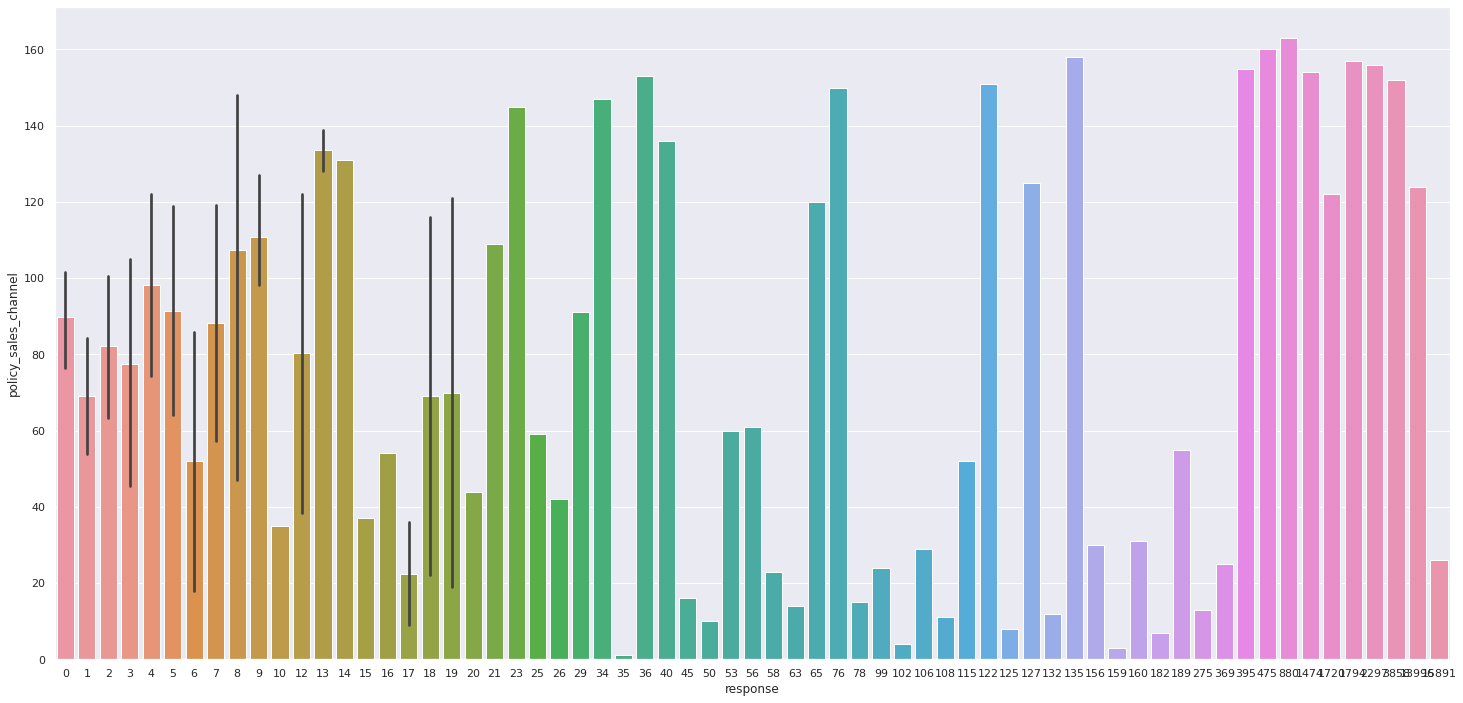

In [39]:
# policy_sales_channel

aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x ='response' , y= 'policy_sales_channel' , data=aux0) 

<AxesSubplot:xlabel='response', ylabel='vintage'>

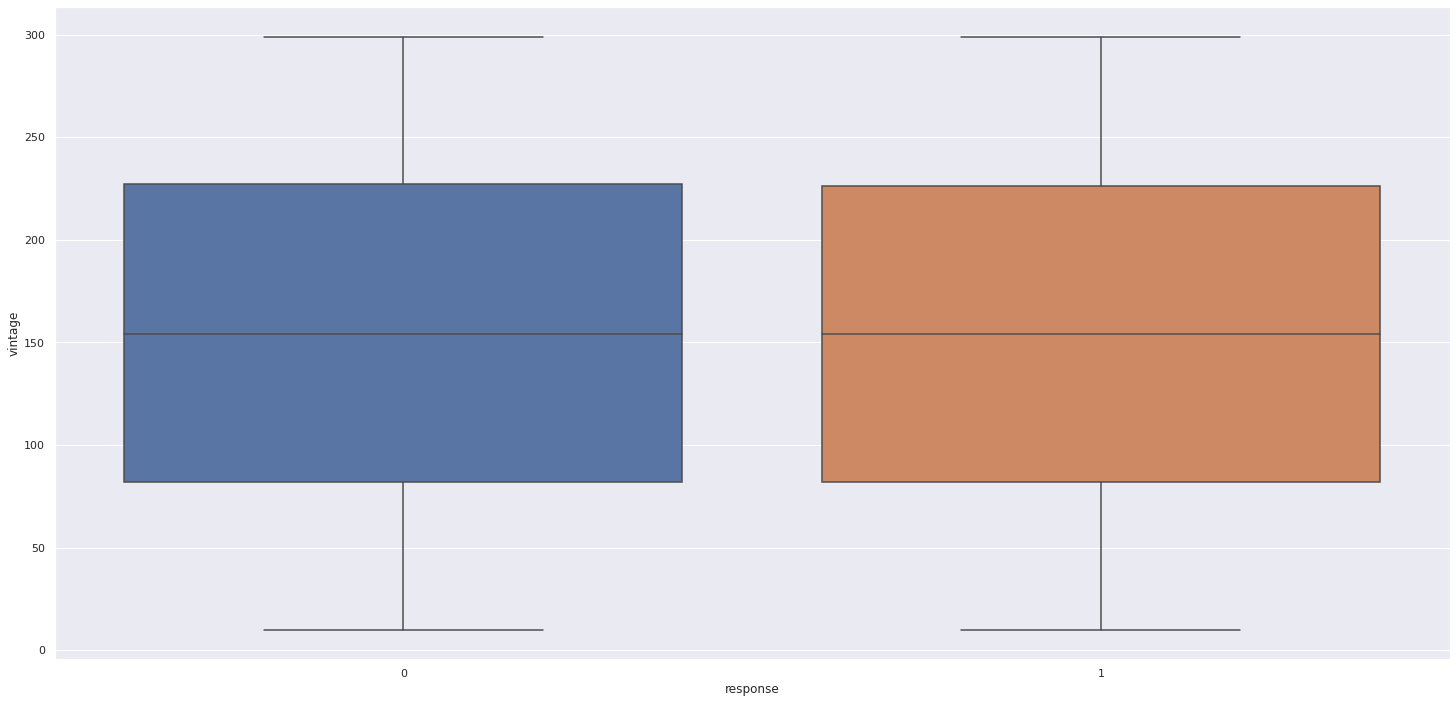

In [40]:
# vintage


sns.boxplot(x ='response' , y = 'vintage' , data=df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

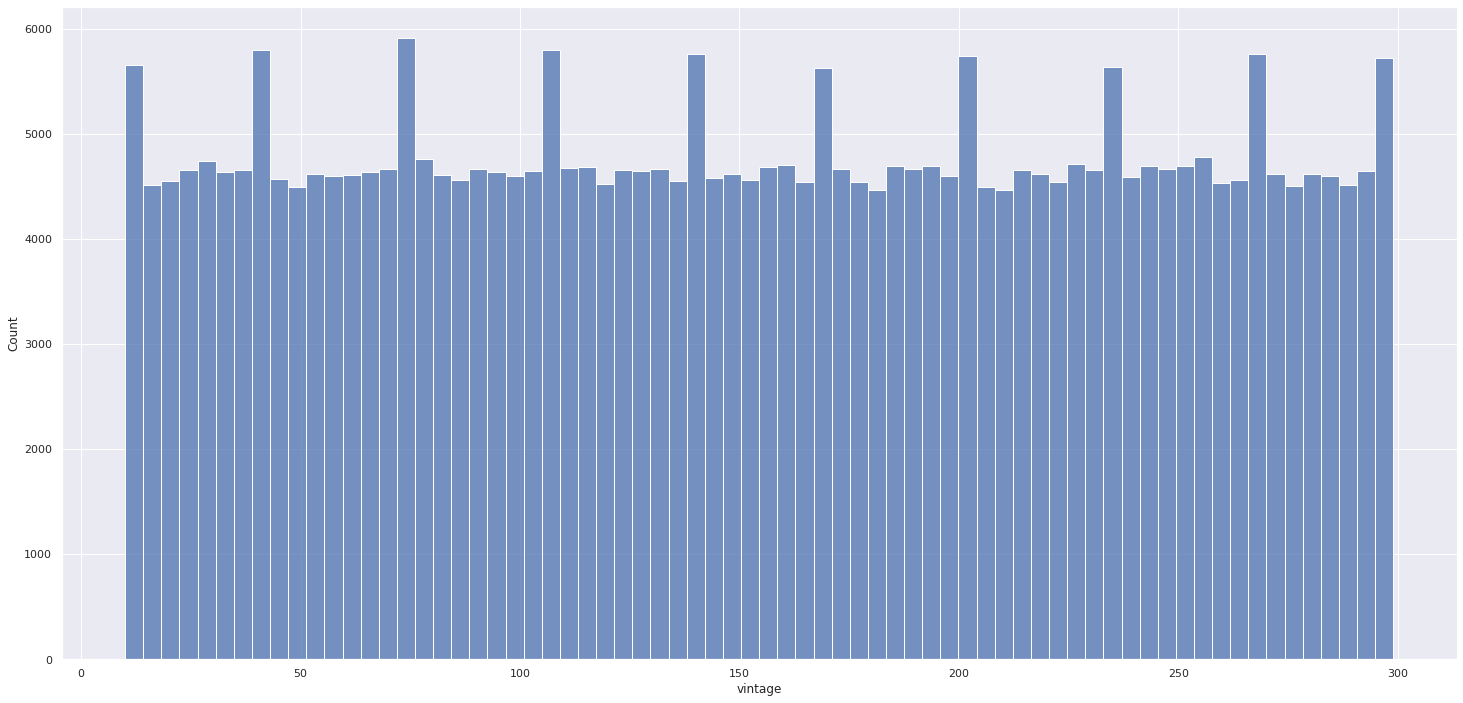

In [41]:
aux00 = df4.loc[df4['response'] == 0,'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

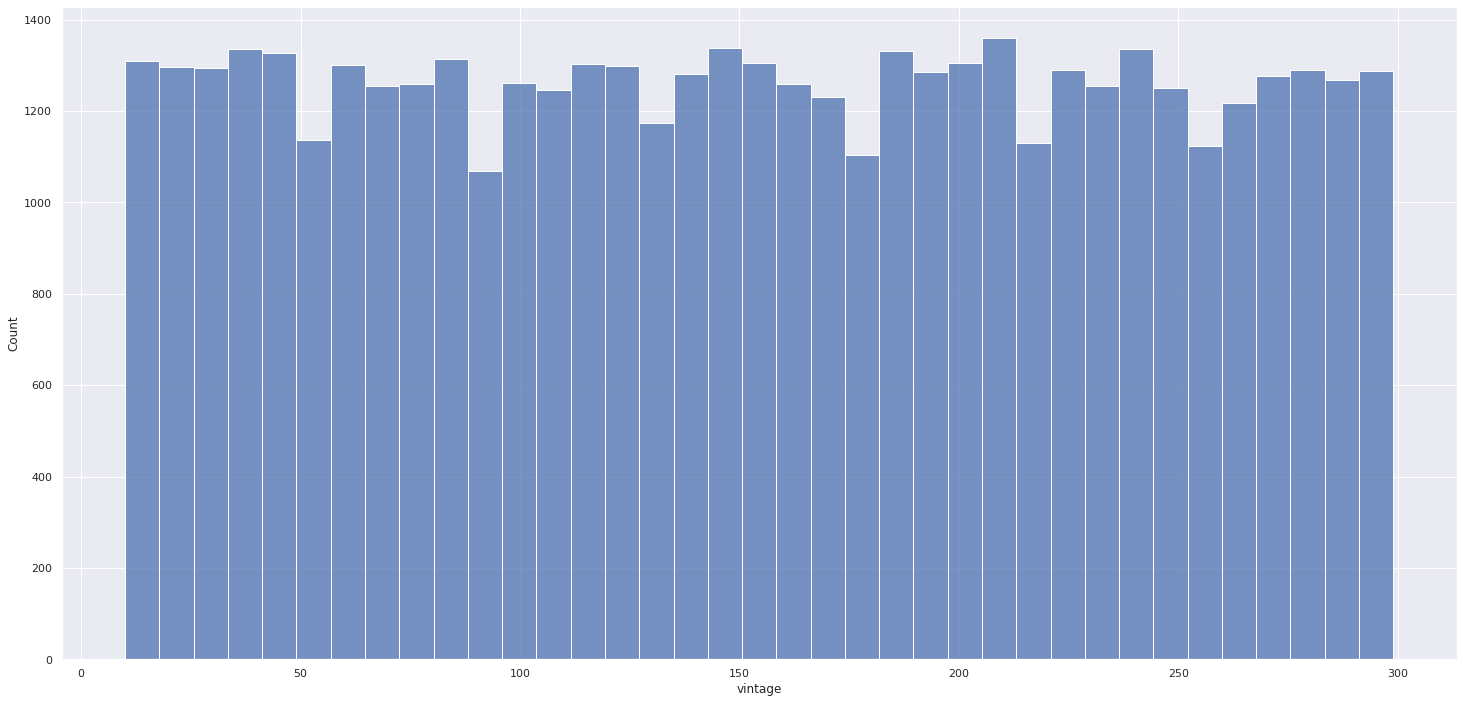

In [42]:
aux00 = df4.loc[df4['response'] == 1,'vintage']
sns.histplot(aux00)

## 4.2. Bivariate Analysis


# 5.0. Data Preparation


In [43]:
df5 = df4.copy()

In [44]:
x = df4.drop('response' , axis=1)
y = df4['response'].copy()


x_train,x_val,y_train,y_val = ms.train_test_split(x,y, test_size = 0.20)

df5 = pd.concat([x_train,y_train], axis=1)

## 5.1. Standardization


In [45]:
ss =pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl' , 'wb'))

## 5.2. Rescaling


In [46]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl' , 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl' , 'wb'))

## 5.3. Encoder


In [47]:
# gender - Target encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[: , 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl' , 'wb'))

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[: , 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl' , 'wb'))

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5 , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[: , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl' , 'wb'))

# fillna
df5 = df5.fillna(0)

## 5.4. Validation Preparation

In [48]:
# gender
x_val.loc[: , 'gender'] = x_val.loc[: , 'gender'].map(target_encode_region_code)

# Age
x_val.loc[: , 'gender'] = mms_age.fit_transform(x_val[['age']].values)

# vintage
x_val['vintage'] = mms_vintage.fit_transform(x_val[['vintage']].values)

# region_code 
x_val.loc[: , 'region_code'] = x_val.loc[: , 'region_code'].map(target_encode_region_code)

# annual_premium
x_val['annual_premium'] = ss.fit_transform(x_val[['annual_premium']].values)

# vehicle_age 
x_val = pd.get_dummies(x_val , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel 
x_val.loc[: , 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_val = x_val.fillna(0)


# 6.0. Feature Selection


In [49]:
df6 = df5.copy()

## 6.1. Feature Importancia

In [50]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis= 1)
y_train_n = y_train.values
forest.fit(x_train_n , y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                feature  importances
0               vintage   0.27250491
0        annual_premium   0.24466917
0                   age   0.16566505
0           region_code   0.10502995
0        vehicle_damage   0.06755500
0  policy_sales_channel   0.05969537
0    previously_insured   0.05663312
0         vehicle_age_0   0.01397462
0         vehicle_age_1   0.00657207
0                gender   0.00509174
0         vehicle_age_2   0.00211036
0       driving_license   0.00049864


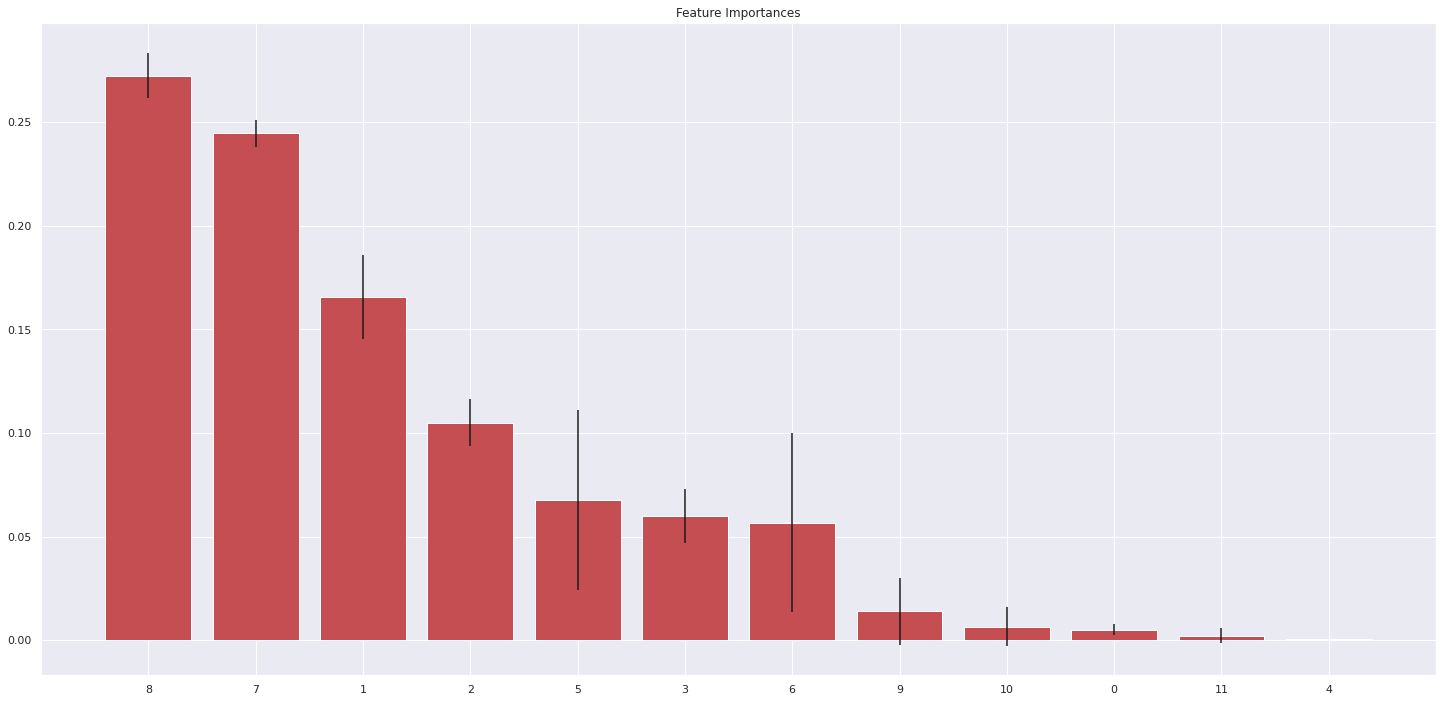

In [51]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_] , axis= 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking: ')
df =pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df,aux], axis = 0)
    
print(df.sort_values('importances', ascending= False))
    
# Plot tge umpurity-based feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color= 'r', yerr= std[indices], align= 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


# 7.0. Machine Learning Modelling


In [52]:
df7 = df6.copy()

In [53]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

df7 = df7[cols_selected]
x_train = df5[cols_selected]
x_validation = x_val[cols_selected]


In [54]:
models=[nk.KNeighborsClassifier(n_neighbors = 500),
       lm.LogisticRegression(random_state = 42),
       #en.RandomForestClassifier( n_estimators=1000,max_depth = 20, n_jobs=-1, random_state=42 ),
       cb( random_state=42, verbose=False )]

In [55]:
%time
ml_results, trained_models = metrics_at_k(df7, models, x_train, y_train, x_validation, y_val, verbose=True )
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
ML - Training model 1/3 -> CatBoostClassifier...
ML - Training model 2/3 -> KNeighborsClassifier...
ML - Training model 3/3 -> LogisticRegression...
CPU times: user 23 µs, sys: 1e+03 ns, total: 24 µs
Wall time: 6.44 µs


In [56]:
ml_results

,Model_Name,Precision@K,Recall@K
0,CatBoostClassifier,0.30080000,0.06430000
0,KNeighborsClassifier,0.14090000,0.03010000
0,LogisticRegression,0.09600000,0.02050000


## Cross-Validation

In [57]:
models_cv =[nk.KNeighborsClassifier(n_neighbors = 500),
            lm.LogisticRegression(random_state = 42),
            #en.RandomForestClassifier( n_estimators=1000,max_depth = 20, n_jobs=-1, random_state=42 ),
            cb( random_state=42, verbose=False )]

In [58]:
cv_results = cross_validation(df7, models_cv, x_train, y_train, 5 )  

In [59]:
ml_cv_results = pd.merge(ml_results, cv_results, on = 'Model_Name', how='left')
ml_cv_results = ml_cv_results.fillna( 0 )

In [60]:
ml_cv_results 

,Model_Name,Precision@K,Recall@K,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,CatBoostClassifier,0.30080000,0.06430000,0.41050000,0.00950000,0.11000000,0.00250000
1,KNeighborsClassifier,0.14090000,0.03010000,0.39420000,0.01900000,0.10560000,0.00510000
2,LogisticRegression,0.09600000,0.02050000,0.36150000,0.04880000,0.09680000,0.01310000


## Ploting Curves

In [61]:
models_cv_plot =[#nk.KNeighborsClassifier(n_neighbors = 500),
           # lm.LogisticRegression(random_state = 42),
            #en.RandomForestClassifier( n_estimators=1000,max_depth = 20, n_jobs=-1, random_state=42 ),
            cb( random_state=42, verbose=False )]

Calulating curve for model 1/1 -> CatBoostClassifier...
Training model ... 


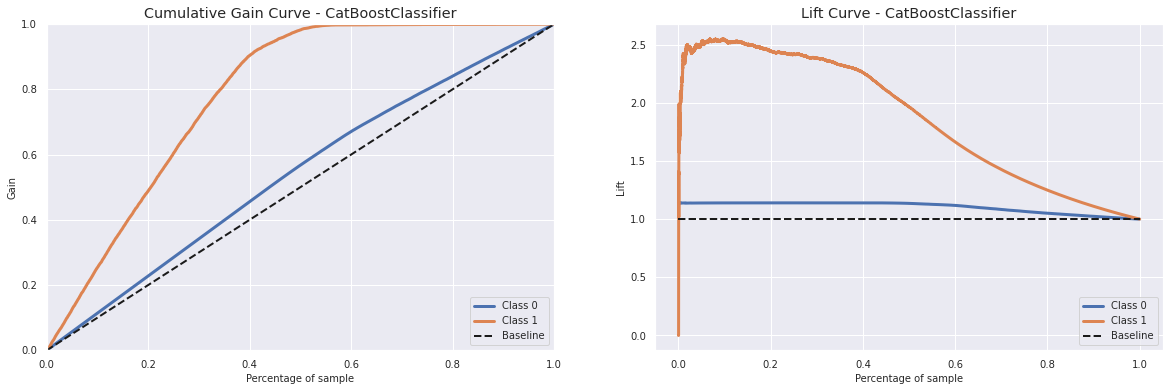

In [62]:
plot_cgc_lc(models_cv_plot, x_train, y_train, x_val, verbose=True) 

# 9.0. Deploy to Production


In [63]:
# save trained model
# pickle.dump(yhat_rf , open('/home/felipepedrosa/projetos/health_insurance/src/model_training_rf.pkl' , 'wb'))


## 9.1. Heatlh Insurance Class

In [64]:
# class HealthInsurance:
    
#     def __init__(self):
#         self.home_path =                      '/home/felipepedrosa/projetos/health_insurance/'
#         self.annual_premium_scaler =           pickle.load(yhat_et , open(self.home_path + 'src/features/annual_premium_scaler.pkl'))
#         self.age_scaler =                      pickle.load(yhat_et , open(self.home_path + 'src/features/age_scaler.pkl'))
#         self.vintage_scaler =                  pickle.load(yhat_et , open(self.home_path + 'src/features/vintage_scaler.pkl'))
#         self.target_encode_gender_scaler =     pickle.load(yhat_et , open(self.home_path + 'src/features/target_encode_gender_scaler.pkl'))
#         self.target_encode_region_scaler =     pickle.load(yhat_et , open(self.home_path + 'src/features/target_encode_region_scaler.pkl'))
#         self.fe_policy_sales_channel_scaler =  pickle.load(yhat_et , open(self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl'))
        
# #     def data_cleaning( self, df1 ):
# #         # 1.1. Rename Columns
# #         cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
# #                     'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# #         # rename 
# #         df1.columns = cols_new
        
# #         return df1 

    
#     def feature_engineering( self, df2 ):
#         # 2.0. Feature Engineering

#         # Vehicle Damage Number
#         df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

#         # Vehicle Age
#         df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
#         return df2
    
    
#     def data_preparation( self, df5 ):
#         # anual premium - StandarScaler
#         df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

#         # Age - MinMaxScaler
#         df5['age'] = self.age_scaler.transform( df5[['age']].values )

#         # Vintage - MinMaxScaler
#         df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

#         # gender - One Hot Encoding / Target Encoding
#         df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

#         # region_code - Target Encoding / Frequency Encoding
#         df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

#         # vehicle_age - One Hot Encoding / Frequency Encoding
#         df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

#         # policy_sales_channel - Target Encoding / Frequency Encoding
#         df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
#         # Feature Selection
#         cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
#                          'policy_sales_channel']
        
#         return df5[ cols_selected ]
    
    
#     def get_prediction( self, model, original_data, test_data ):
#         # model prediction
#         pred = model.predict_proba( test_data )
        
#         # join prediction into original data
#         original_data['prediction'] = pred
        
#         return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Hanlder

In [65]:
# # loading model
# path = '/home/felipepedrosa/projetos/health_insurance/'
# model = pickle.load( open( path + 'src/model_training_rf.pkl', 'rb' ) )

# # initialize API
# app = Flask( __name__ )

# @app.route( '/predict', methods=['POST'] )

# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json: # there is data
#         if isinstance( test_json, dict ): # unique example
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: # multiple example
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
#         # Instantiate Rossmann class
#         pipeline = HealthInsurance()
        
#         # data cleaning
# #         df1 = pipeline.data_cleaning( test_raw )
        
#         # feature engineering
#         df2 = pipeline.feature_engineering( test_raw )
        
#         # data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         # prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
    
#     else:
#         return Response( '{}', status=200, mimetype='application/json' )
    
# if __name__ == '__main__':
#     app.run( '0.0.0.0', debug=True )

## 9.3. API Tester


In [66]:
# loading test dataset

df_test = x_val
df_test['response'] = y_val

In [67]:
df_test = df_test.sample(10)

In [68]:
df_test.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_0,vehicle_age_1,vehicle_age_2,response
242473,31684,0.86153846,76,0.12503376,0.20924474,1,1,0,0.05502714,0.58823529,0,1,0,0
96179,5298,0.03076923,22,0.10367171,0.35364250,1,0,0,-0.27292579,0.34948097,1,0,0,0
145963,24322,0.16923077,31,0.18739311,0.20924474,1,1,0,0.07182115,0.19031142,1,0,0,0
235084,353121,0.00000000,20,0.09441052,0.05676857,1,0,1,-0.06810935,0.27335640,1,0,0,0
322545,291156,0.06153846,24,0.07005364,0.35364250,1,1,0,0.07610773,0.47750865,1,0,0,1


In [69]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.00000000,152.00000000,1,0,1,0,23367.00000000,249,0
1,13,Female,41,15.00000000,14.00000000,1,1,0,1,31409.00000000,221,0
2,18,Female,25,35.00000000,152.00000000,1,0,0,1,46622.00000000,299,0
3,31,Female,26,8.00000000,160.00000000,1,0,0,0,2630.00000000,136,0
4,39,Male,45,8.00000000,124.00000000,1,1,1,0,42297.00000000,264,0


In [70]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [71]:
data

'[{"id": 31684, "gender": 0.8615384615384616, "age": 76, "region_code": 0.1250337564137186, "policy_sales_channel": 0.20924473657453418, "driving_license": 1, "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 0.05502714317162684, "vintage": 0.5882352941176471, "vehicle_age_0": 0, "vehicle_age_1": 1, "vehicle_age_2": 0, "response": 0}, {"id": 5298, "gender": 0.03076923076923077, "age": 22, "region_code": 0.10367170626349892, "policy_sales_channel": 0.3536424970562864, "driving_license": 1, "vehicle_damage": 0, "previously_insured": 0, "annual_premium": -0.2729257946434698, "vintage": 0.3494809688581315, "vehicle_age_0": 1, "vehicle_age_1": 0, "vehicle_age_2": 0, "response": 0}, {"id": 24322, "gender": 0.16923076923076924, "age": 31, "region_code": 0.18739310732610173, "policy_sales_channel": 0.20924473657453418, "driving_license": 1, "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 0.07182115216269536, "vintage": 0.1903114186851211, "vehicle_age_0": 1, "vehi

In [72]:
# API Call

url = 'http://0.0.0.0:5000/predict'
header = {'Content-type': 'application/json'}     

r = requests.post(url , data = data , headers = header)
print('Status code {}'.format(r.status_code))

Status code 500


In [73]:
d1 = pd.DataFrame(r.json(), columns = r.json([0].keys()))
d1.sort_values('score', ascending = False).head()

JSONDecodeError: [Errno Expecting value] <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
  "http://www.w3.org/TR/html4/loose.dtd">
<html>
  <head>
    <title>KeyError: &#x27;vehicle_age&#x27; // Werkzeug Debugger</title>
    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css"
        type="text/css">
    <!-- We need to make sure this has a favicon so that the debugger does
         not accidentally trigger a request to /favicon.ico which might
         change the application's state. -->
    <link rel="shortcut icon"
        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>
    <script type="text/javascript">
      var TRACEBACK = 140596824587616,
          CONSOLE_MODE = false,
          EVALEX = true,
          EVALEX_TRUSTED = false,
          SECRET = "63AOWS18SDkTi1KZ3nSm";
    </script>
  </head>
  <body style="background-color: #fff">
    <div class="debugger">
<h1>KeyError</h1>
<div class="detail">
  <p class="errormsg">KeyError: &#x27;vehicle_age&#x27;</p>
</div>
<h2 class="traceback">Traceback <em>(most recent call last)</em></h2>
<div class="traceback">
  <h3></h3>
  <ul><li><div class="frame" id="frame-140596824587952">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/indexes/base.py"</cite>,
      line <em class="line">3621</em>,
      in <code class="function">get_loc</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">                    </span>&quot;tolerance argument only valid if using pad, &quot;</pre>
<pre class="line before"><span class="ws">                    </span>&quot;backfill or nearest lookups&quot;</pre>
<pre class="line before"><span class="ws">                </span>)</pre>
<pre class="line before"><span class="ws">            </span>casted_key = self._maybe_cast_indexer(key)</pre>
<pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line current"><span class="ws">                </span>return self._engine.get_loc(casted_key)</pre>
<pre class="line after"><span class="ws">            </span>except KeyError as err:</pre>
<pre class="line after"><span class="ws">                </span>raise KeyError(key) from err</pre>
<pre class="line after"><span class="ws">            </span>except TypeError:</pre>
<pre class="line after"><span class="ws">                </span># If we have a listlike key, _check_indexing_error will raise</pre>
<pre class="line after"><span class="ws">                </span>#  InvalidIndexError. Otherwise we fall through and re-raise</pre></div>
</div>

<li><div class="frame" id="frame-140596824588240">
  <h4>File <cite class="filename">"pandas/_libs/index.pyx"</cite>,
      line <em class="line">136</em>,
      in <code class="function">pandas._libs.index.IndexEngine.get_loc</code></h4>
  <div class="source "><pre class="line current"><span class="ws"></span> </pre></div>
</div>

<li><div class="frame" id="frame-140596824588192">
  <h4>File <cite class="filename">"pandas/_libs/index.pyx"</cite>,
      line <em class="line">163</em>,
      in <code class="function">pandas._libs.index.IndexEngine.get_loc</code></h4>
  <div class="source "><pre class="line current"><span class="ws"></span> </pre></div>
</div>

<li><div class="frame" id="frame-140596824588000">
  <h4>File <cite class="filename">"pandas/_libs/hashtable_class_helper.pxi"</cite>,
      line <em class="line">5198</em>,
      in <code class="function">pandas._libs.hashtable.PyObjectHashTable.get_item</code></h4>
  <div class="source "><pre class="line current"><span class="ws"></span> </pre></div>
</div>

<li><div class="frame" id="frame-140596824587424">
  <h4>File <cite class="filename">"pandas/_libs/hashtable_class_helper.pxi"</cite>,
      line <em class="line">5206</em>,
      in <code class="function">pandas._libs.hashtable.PyObjectHashTable.get_item</code></h4>
  <div class="source "><pre class="line current"><span class="ws"></span> </pre></div>
</div>

<li><div class="exc-divider">The above exception was the direct cause of the following exception:</div>
<li><div class="frame" id="frame-140596824587760">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2091</em>,
      in <code class="function">__call__</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">    </span>def __call__(self, environ: dict, start_response: t.Callable) -&gt; t.Any:</pre>
<pre class="line before"><span class="ws">        </span>&quot;&quot;&quot;The WSGI server calls the Flask application object as the</pre>
<pre class="line before"><span class="ws">        </span>WSGI application. This calls :meth:`wsgi_app`, which can be</pre>
<pre class="line before"><span class="ws">        </span>wrapped to apply middleware.</pre>
<pre class="line before"><span class="ws">        </span>&quot;&quot;&quot;</pre>
<pre class="line current"><span class="ws">        </span>return self.wsgi_app(environ, start_response)</pre></div>
</div>

<li><div class="frame" id="frame-140596824587520">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2076</em>,
      in <code class="function">wsgi_app</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line before"><span class="ws">                </span>ctx.push()</pre>
<pre class="line before"><span class="ws">                </span>response = self.full_dispatch_request()</pre>
<pre class="line before"><span class="ws">            </span>except Exception as e:</pre>
<pre class="line before"><span class="ws">                </span>error = e</pre>
<pre class="line current"><span class="ws">                </span>response = self.handle_exception(e)</pre>
<pre class="line after"><span class="ws">            </span>except:  # noqa: B001</pre>
<pre class="line after"><span class="ws">                </span>error = sys.exc_info()[1]</pre>
<pre class="line after"><span class="ws">                </span>raise</pre>
<pre class="line after"><span class="ws">            </span>return response(environ, start_response)</pre>
<pre class="line after"><span class="ws">        </span>finally:</pre></div>
</div>

<li><div class="frame" id="frame-140596824587472">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2073</em>,
      in <code class="function">wsgi_app</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>ctx = self.request_context(environ)</pre>
<pre class="line before"><span class="ws">        </span>error: t.Optional[BaseException] = None</pre>
<pre class="line before"><span class="ws">        </span>try:</pre>
<pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line before"><span class="ws">                </span>ctx.push()</pre>
<pre class="line current"><span class="ws">                </span>response = self.full_dispatch_request()</pre>
<pre class="line after"><span class="ws">            </span>except Exception as e:</pre>
<pre class="line after"><span class="ws">                </span>error = e</pre>
<pre class="line after"><span class="ws">                </span>response = self.handle_exception(e)</pre>
<pre class="line after"><span class="ws">            </span>except:  # noqa: B001</pre>
<pre class="line after"><span class="ws">                </span>error = sys.exc_info()[1]</pre></div>
</div>

<li><div class="frame" id="frame-140596824588096">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1518</em>,
      in <code class="function">full_dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>request_started.send(self)</pre>
<pre class="line before"><span class="ws">            </span>rv = self.preprocess_request()</pre>
<pre class="line before"><span class="ws">            </span>if rv is None:</pre>
<pre class="line before"><span class="ws">                </span>rv = self.dispatch_request()</pre>
<pre class="line before"><span class="ws">        </span>except Exception as e:</pre>
<pre class="line current"><span class="ws">            </span>rv = self.handle_user_exception(e)</pre>
<pre class="line after"><span class="ws">        </span>return self.finalize_request(rv)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def finalize_request(</pre>
<pre class="line after"><span class="ws">        </span>self,</pre>
<pre class="line after"><span class="ws">        </span>rv: t.Union[ResponseReturnValue, HTTPException],</pre></div>
</div>

<li><div class="frame" id="frame-140596824586848">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1516</em>,
      in <code class="function">full_dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>self.try_trigger_before_first_request_functions()</pre>
<pre class="line before"><span class="ws">        </span>try:</pre>
<pre class="line before"><span class="ws">            </span>request_started.send(self)</pre>
<pre class="line before"><span class="ws">            </span>rv = self.preprocess_request()</pre>
<pre class="line before"><span class="ws">            </span>if rv is None:</pre>
<pre class="line current"><span class="ws">                </span>rv = self.dispatch_request()</pre>
<pre class="line after"><span class="ws">        </span>except Exception as e:</pre>
<pre class="line after"><span class="ws">            </span>rv = self.handle_user_exception(e)</pre>
<pre class="line after"><span class="ws">        </span>return self.finalize_request(rv)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def finalize_request(</pre></div>
</div>

<li><div class="frame" id="frame-140596824587184">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1502</em>,
      in <code class="function">dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>getattr(rule, &quot;provide_automatic_options&quot;, False)</pre>
<pre class="line before"><span class="ws">            </span>and req.method == &quot;OPTIONS&quot;</pre>
<pre class="line before"><span class="ws">        </span>):</pre>
<pre class="line before"><span class="ws">            </span>return self.make_default_options_response()</pre>
<pre class="line before"><span class="ws">        </span># otherwise dispatch to the handler for that endpoint</pre>
<pre class="line current"><span class="ws">        </span>return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def full_dispatch_request(self) -&gt; Response:</pre>
<pre class="line after"><span class="ws">        </span>&quot;&quot;&quot;Dispatches the request and on top of that performs request</pre>
<pre class="line after"><span class="ws">        </span>pre and postprocessing as well as HTTP exception catching and</pre>
<pre class="line after"><span class="ws">        </span>error handling.</pre></div>
</div>

<li><div class="frame" id="frame-140596824587664">
  <h4>File <cite class="filename">"/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/handler.py"</cite>,
      line <em class="line">34</em>,
      in <code class="function">health_insurance_predict</code></h4>
  <div class="source "><pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">        </span># data cleaning</pre>
<pre class="line before"><span class="ws"></span>#         df1 = pipeline.data_cleaning( test_raw )</pre>
<pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">        </span># feature engineering</pre>
<pre class="line current"><span class="ws">        </span>df2 = pipeline.feature_engineering( test_raw )</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">        </span># data preparation</pre>
<pre class="line after"><span class="ws">        </span>df3 = pipeline.data_preparation( df2 )</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">        </span># prediction</pre></div>
</div>

<li><div class="frame" id="frame-140596824587712">
  <h4>File <cite class="filename">"/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/healthinsurance/HealthInsurance.py"</cite>,
      line <em class="line">36</em>,
      in <code class="function">feature_engineering</code></h4>
  <div class="source "><pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">        </span># Vehicle Damage Number</pre>
<pre class="line before"><span class="ws">        </span>df2[&#x27;vehicle_damage&#x27;] = df2[&#x27;vehicle_damage&#x27;].apply( lambda x: 1 if x == &#x27;Yes&#x27; else 0 ).astype(int)</pre>
<pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">        </span># Vehicle Age</pre>
<pre class="line current"><span class="ws">        </span>df2[&#x27;vehicle_age&#x27;] =  df2[&#x27;vehicle_age&#x27;].apply( lambda x: 2 if x == &#x27;&gt; 2 Years&#x27; else 1 if x == &#x27;1-2 Year&#x27; else 0 ).astype(int)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">        </span>return df2</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def data_preparation( self, df5 ):</pre></div>
</div>

<li><div class="frame" id="frame-140596824587568">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/frame.py"</cite>,
      line <em class="line">3505</em>,
      in <code class="function">__getitem__</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>is_single_key = isinstance(key, tuple) or not is_list_like(key)</pre>
<pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">        </span>if is_single_key:</pre>
<pre class="line before"><span class="ws">            </span>if self.columns.nlevels &gt; 1:</pre>
<pre class="line before"><span class="ws">                </span>return self._getitem_multilevel(key)</pre>
<pre class="line current"><span class="ws">            </span>indexer = self.columns.get_loc(key)</pre>
<pre class="line after"><span class="ws">            </span>if is_integer(indexer):</pre>
<pre class="line after"><span class="ws">                </span>indexer = [indexer]</pre>
<pre class="line after"><span class="ws">        </span>else:</pre>
<pre class="line after"><span class="ws">            </span>if is_iterator(key):</pre>
<pre class="line after"><span class="ws">                </span>key = list(key)</pre></div>
</div>

<li><div class="frame" id="frame-140596824587232">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/indexes/base.py"</cite>,
      line <em class="line">3623</em>,
      in <code class="function">get_loc</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">                </span>)</pre>
<pre class="line before"><span class="ws">            </span>casted_key = self._maybe_cast_indexer(key)</pre>
<pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line before"><span class="ws">                </span>return self._engine.get_loc(casted_key)</pre>
<pre class="line before"><span class="ws">            </span>except KeyError as err:</pre>
<pre class="line current"><span class="ws">                </span>raise KeyError(key) from err</pre>
<pre class="line after"><span class="ws">            </span>except TypeError:</pre>
<pre class="line after"><span class="ws">                </span># If we have a listlike key, _check_indexing_error will raise</pre>
<pre class="line after"><span class="ws">                </span>#  InvalidIndexError. Otherwise we fall through and re-raise</pre>
<pre class="line after"><span class="ws">                </span>#  the TypeError.</pre>
<pre class="line after"><span class="ws">                </span>self._check_indexing_error(key)</pre></div>
</div>
</ul>
  <blockquote>KeyError: &#x27;vehicle_age&#x27;</blockquote>
</div>

<div class="plain">
    <p>
      This is the Copy/Paste friendly version of the traceback.
    </p>
    <textarea cols="50" rows="10" name="code" readonly>Traceback (most recent call last):
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/indexes/base.py&quot;, line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File &quot;pandas/_libs/index.pyx&quot;, line 136, in pandas._libs.index.IndexEngine.get_loc
    
  File &quot;pandas/_libs/index.pyx&quot;, line 163, in pandas._libs.index.IndexEngine.get_loc
    
  File &quot;pandas/_libs/hashtable_class_helper.pxi&quot;, line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
    
  File &quot;pandas/_libs/hashtable_class_helper.pxi&quot;, line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
    
KeyError: &#x27;vehicle_age&#x27;

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 2091, in __call__
    return self.wsgi_app(environ, start_response)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 2076, in wsgi_app
    response = self.handle_exception(e)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File &quot;/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/handler.py&quot;, line 34, in health_insurance_predict
    df2 = pipeline.feature_engineering( test_raw )
  File &quot;/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/healthinsurance/HealthInsurance.py&quot;, line 36, in feature_engineering
    df2[&#x27;vehicle_age&#x27;] =  df2[&#x27;vehicle_age&#x27;].apply( lambda x: 2 if x == &#x27;&gt; 2 Years&#x27; else 1 if x == &#x27;1-2 Year&#x27; else 0 ).astype(int)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/frame.py&quot;, line 3505, in __getitem__
    indexer = self.columns.get_loc(key)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/indexes/base.py&quot;, line 3623, in get_loc
    raise KeyError(key) from err
KeyError: &#x27;vehicle_age&#x27;</textarea>
</div>
<div class="explanation">
  The debugger caught an exception in your WSGI application.  You can now
  look at the traceback which led to the error.  <span class="nojavascript">
  If you enable JavaScript you can also use additional features such as code
  execution (if the evalex feature is enabled), automatic pasting of the
  exceptions and much more.</span>
</div>
      <div class="footer">
        Brought to you by <strong class="arthur">DON'T PANIC</strong>, your
        friendly Werkzeug powered traceback interpreter.
      </div>
    </div>

    <div class="pin-prompt">
      <div class="inner">
        <h3>Console Locked</h3>
        <p>
          The console is locked and needs to be unlocked by entering the PIN.
          You can find the PIN printed out on the standard output of your
          shell that runs the server.
        <form>
          <p>PIN:
            <input type=text name=pin size=14>
            <input type=submit name=btn value="Confirm Pin">
        </form>
      </div>
    </div>
  </body>
</html>

<!--

Traceback (most recent call last):
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
    
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
    
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
    
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
    
KeyError: 'vehicle_age'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 2091, in __call__
    return self.wsgi_app(environ, start_response)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 2076, in wsgi_app
    response = self.handle_exception(e)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/handler.py", line 34, in health_insurance_predict
    df2 = pipeline.feature_engineering( test_raw )
  File "/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/healthinsurance/HealthInsurance.py", line 36, in feature_engineering
    df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 2 if x == '> 2 Years' else 1 if x == '1-2 Year' else 0 ).astype(int)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/frame.py", line 3505, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3623, in get_loc
    raise KeyError(key) from err
KeyError: 'vehicle_age'

-->
: 0